<a href="https://colab.research.google.com/github/jeremysb1/xgboost/blob/main/best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data = pd.read_csv("/content/drive/MyDrive/XGBoost/AB_NYC_2019.csv")
excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id',
                  'last_review', 'name', 'host_name']
low_card_categorical = ['neighbourhood_group', 'room_type']
high_card_categorical = ['neighbourhood']
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
              'calculated_host_listings_count', 'availability_365']
target_mean = (data["price"] > data["price"].mean()).astype(int)
target_median = (data["price"] > data["price"].median()).astype(int)
target_multiclass = pd.qcut(data["price"], q=5, labels=False)
target_regression = data["price"]
categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore')
categorical_ord_encoding = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
numeric_standardization = Pipeline([('StandardScaler', StandardScaler()),
                                    ('Imputer', SimpleImputer(strategy="constant", fill_value=0))])

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', categorical_ord_encoding, high_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0)

lm_column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0)


## Multivariate missing data imputation

Multivariate imputation:

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

Xm = data[continuous].copy()
missing_percentage = 0.05
np.random.seed(0)
mask = np.random.rand(*Xm.shape) < missing_percentage
Xm[mask] = np.nan

simple_imputer = SimpleImputer()
Xm_si = simple_imputer.fit_transform(Xm)

rf = RandomForestRegressor(random_state=0, n_jobs=-1)
multivariate_imputer = IterativeImputer(estimator=rf, max_iter=1, tol=0.01)
Xm_mi = multivariate_imputer.fit_transform(Xm)

mae = pd.DataFrame({"simple": np.mean(np.abs(data[continuous] - Xm_si), axis=0),
                    "multivariate": np.mean(np.abs(data[continuous] - Xm_mi), axis=0)},
                   index = continuous)

print(mae)

                                  simple  multivariate
minimum_nights                  0.347355      0.260156
number_of_reviews               1.327776      0.858506
reviews_per_month               0.057980      0.036876
calculated_host_listings_count  0.579423      0.368567
availability_365                6.025748      4.622640


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Target Encoding

Creating a high cardinality categorical feature:

In [8]:
def bin_2_cat(feature, bins=100):
    min_value = feature.min()
    bin_size = (feature.max() - min_value) / bins
    return ((feature - min_value) / bin_size).astype(int)

data['coordinates'] = bin_2_cat(data['latitude']) * 1000 + bin_2_cat(data['longitude'])
high_card_categorical += ['coordinates']

print(data[high_card_categorical].nunique())

neighbourhood     221
coordinates      2259
dtype: int64


Using target encoding in the pipeline:

In [10]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 995.2 kB/s eta 0:00:00


In [12]:
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, make_scorer

target_encoder = TargetEncoder(cols=high_card_categorical, smoothing=0.5)

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
xgb = XGBClassifier(booster = 'gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3)

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', target_encoder, high_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0)

model_pipeline = Pipeline([('processing', column_transform),
                        ('xgb', xgb)])

cv_scores = cross_validate(estimator = model_pipeline,
                           X= data,
                           y = target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])

print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")

0.840 (0.002) fit: 5.26 secs pred: 0.08 secs


Partial Dependence Plot:

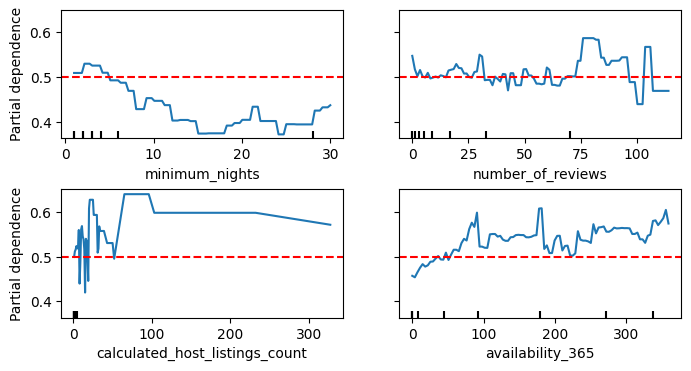

In [16]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

xgb = XGBClassifier(booster = 'gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3)

model_pipeline = Pipeline([('processing', column_transform),
                        ('xgb', xgb)])

model_pipeline.fit(X=data, y=target_median)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

PartialDependenceDisplay.from_estimator(model_pipeline,
                                        X=data,
                                        kind='average',
                                        features=['minimum_nights',
                                                  'number_of_reviews',
                                                  'calculated_host_listings_count',
                                                  'availability_365'],
                                        ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--')

plt.show()

Above is a panel of Partial Dependency Plots for numeric features.

ICE plots:

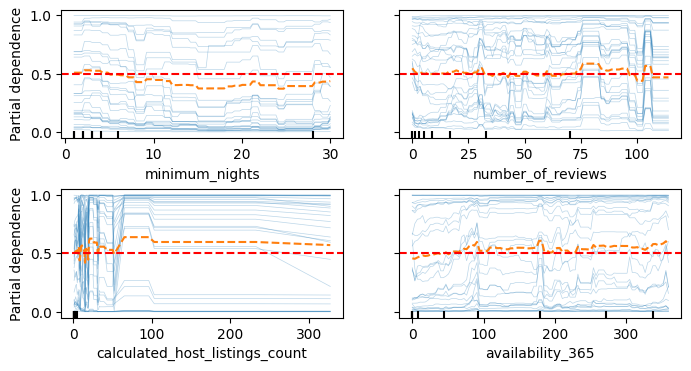

In [17]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

PartialDependenceDisplay.from_estimator(model_pipeline,
                                        X=data,
                                        kind='both',
                                        subsample=30,
                                        features=['minimum_nights',
                                                  'number_of_reviews',
                                                  'calculated_host_listings_count',
                                                  'availability_365'],
                                       ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--')
    ax.legend().set_visible(False)

plt.show()

Partial Dependence Plot for binary features:

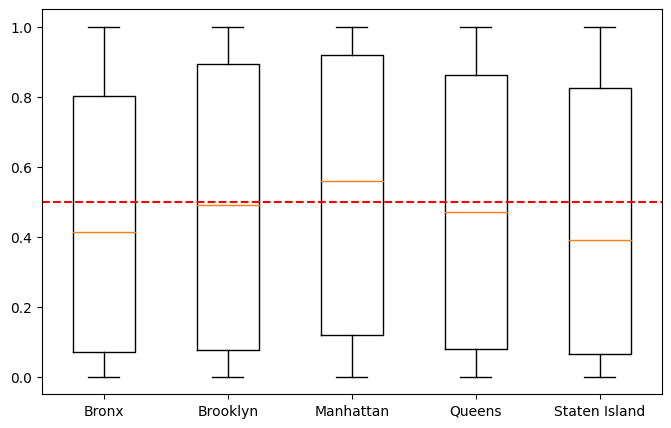

In [18]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

pd_ice = partial_dependence(model_pipeline, X=data,
                            features=['neighbourhood_group'],
                            kind='both')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
labels = np.ravel(pd_ice['values'])
plt.boxplot(pd_ice["individual"].squeeze(), labels=labels)
ax.axhline(y=0.5, color='red', linestyle='--')
plt.show()